**Подключение библиотек и скриптов**

In [159]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [160]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [161]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [162]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [163]:
def show_feature_importances(feature_names, feature_importances, get_top=None, get_list=False):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x=feature_importances['importance'], y=feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
    if get_list:
        return feature_importances.sort_values('importance', ascending=False)

In [164]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [165]:
# input
TRAIN_DATASET_PATH = 'credit-default/train.csv'
TEST_DATASET_PATH = 'credit-default/test.csv'

# output
MODEL_FILE_PATH = 'model.pkl'
PREDICTION_PATH = 'credit-default/submission.csv'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [166]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [167]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [168]:
df_train[df_train['Credit Default'] == 0].count()

Home Ownership                  5387
Annual Income                   4359
Years in current job            5153
Tax Liens                       5387
Number of Open Accounts         5387
Years of Credit History         5387
Maximum Open Credit             5387
Number of Credit Problems       5387
Months since last delinquent    2436
Bankruptcies                    5377
Purpose                         5387
Term                            5387
Current Loan Amount             5387
Current Credit Balance          5387
Monthly Debt                    5387
Credit Score                    4359
Credit Default                  5387
dtype: int64

In [169]:
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [170]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [171]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Пропуски в Annual Income, Years in current job, Months since last delinquent, Bankruptcies и Credit Score

In [172]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Пропуски в Annual Income, Years in current job, Months since last delinquent, Bankruptcies и Credit Score

In [173]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


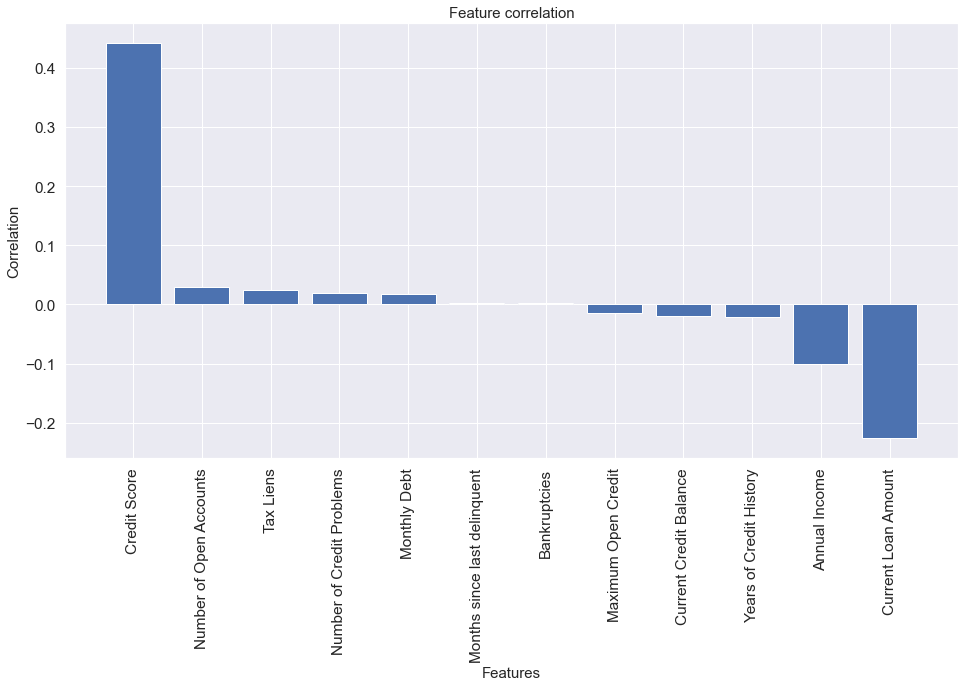

In [174]:
correlation = df_train.corrwith(df_train['Credit Default']).sort_values(ascending=False)
correlation.drop('Credit Default', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

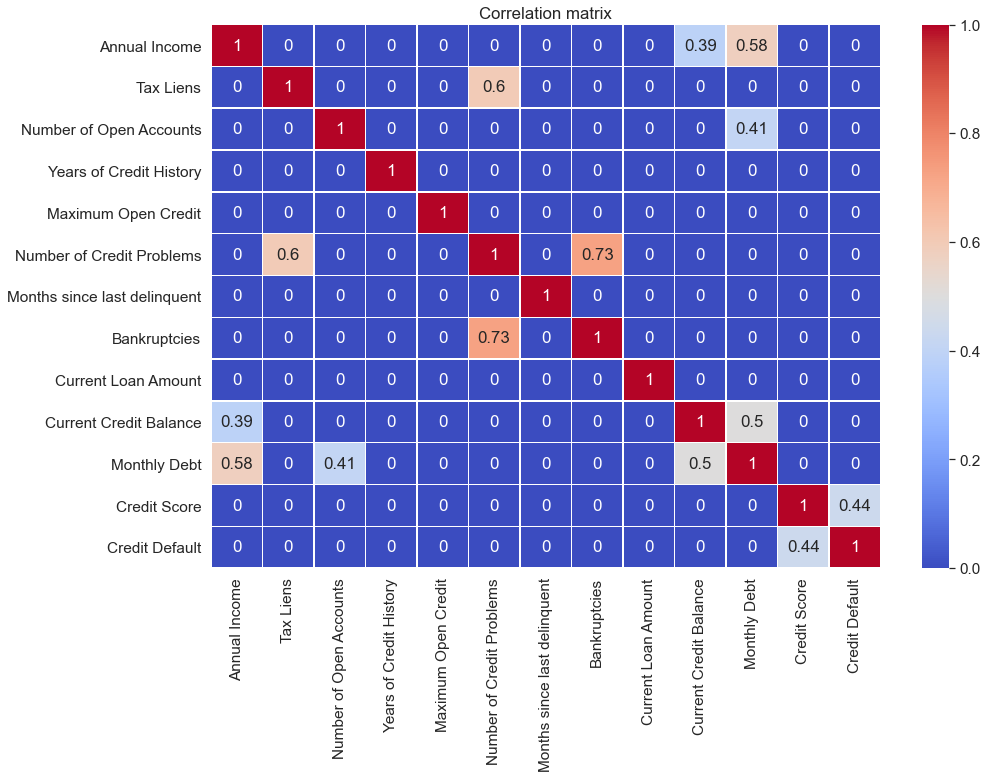

In [175]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

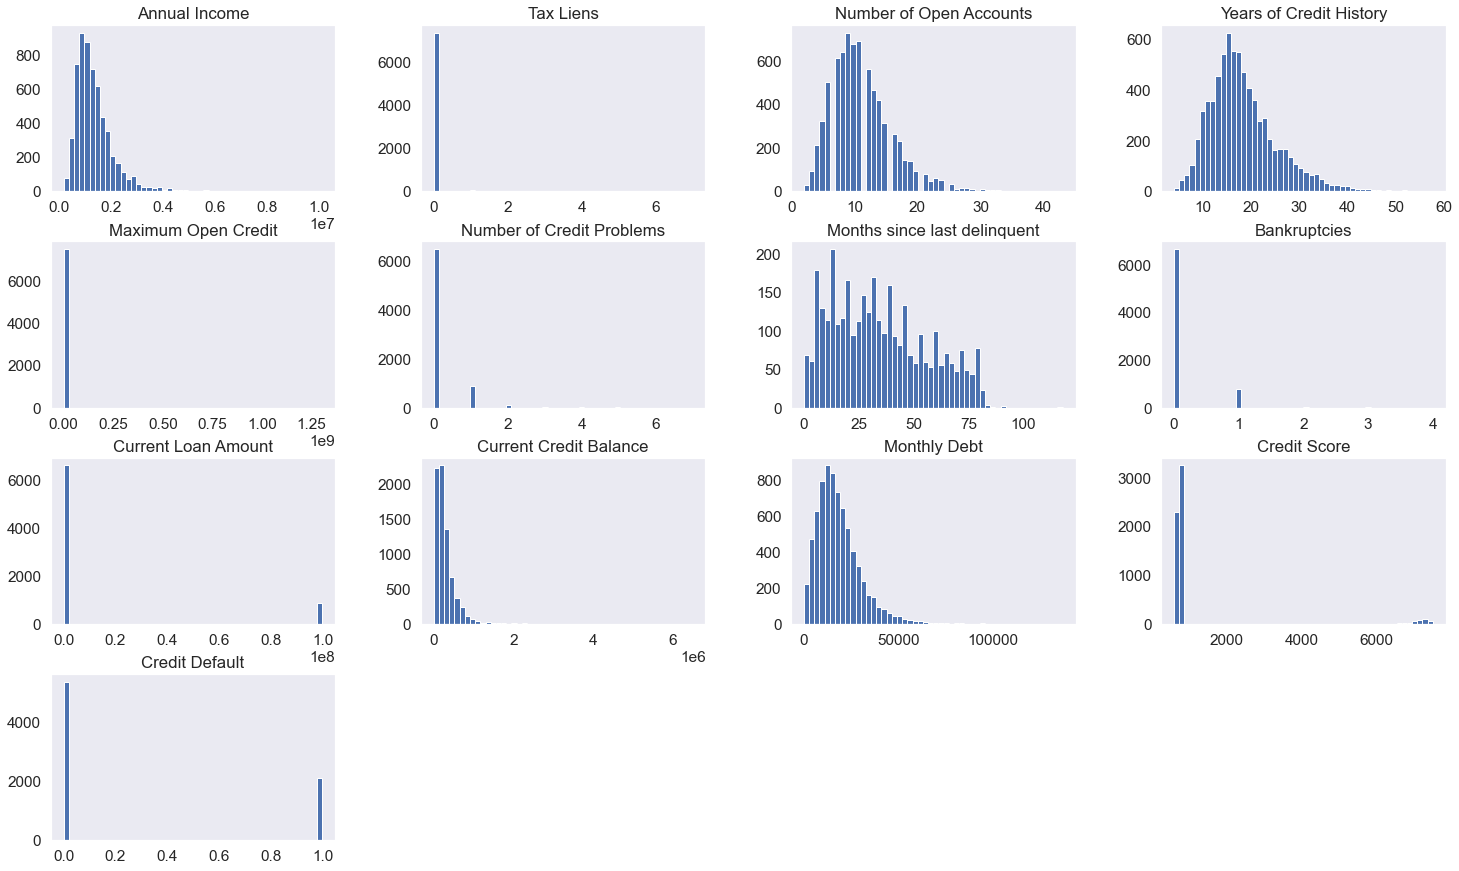

In [176]:
#df_train.select_dtypes(exclude=['object']).hist(figsize=(25,15), bins=50, grid=False)
df_train.hist(figsize=(25,15), bins=50, grid=False)

<AxesSubplot:>

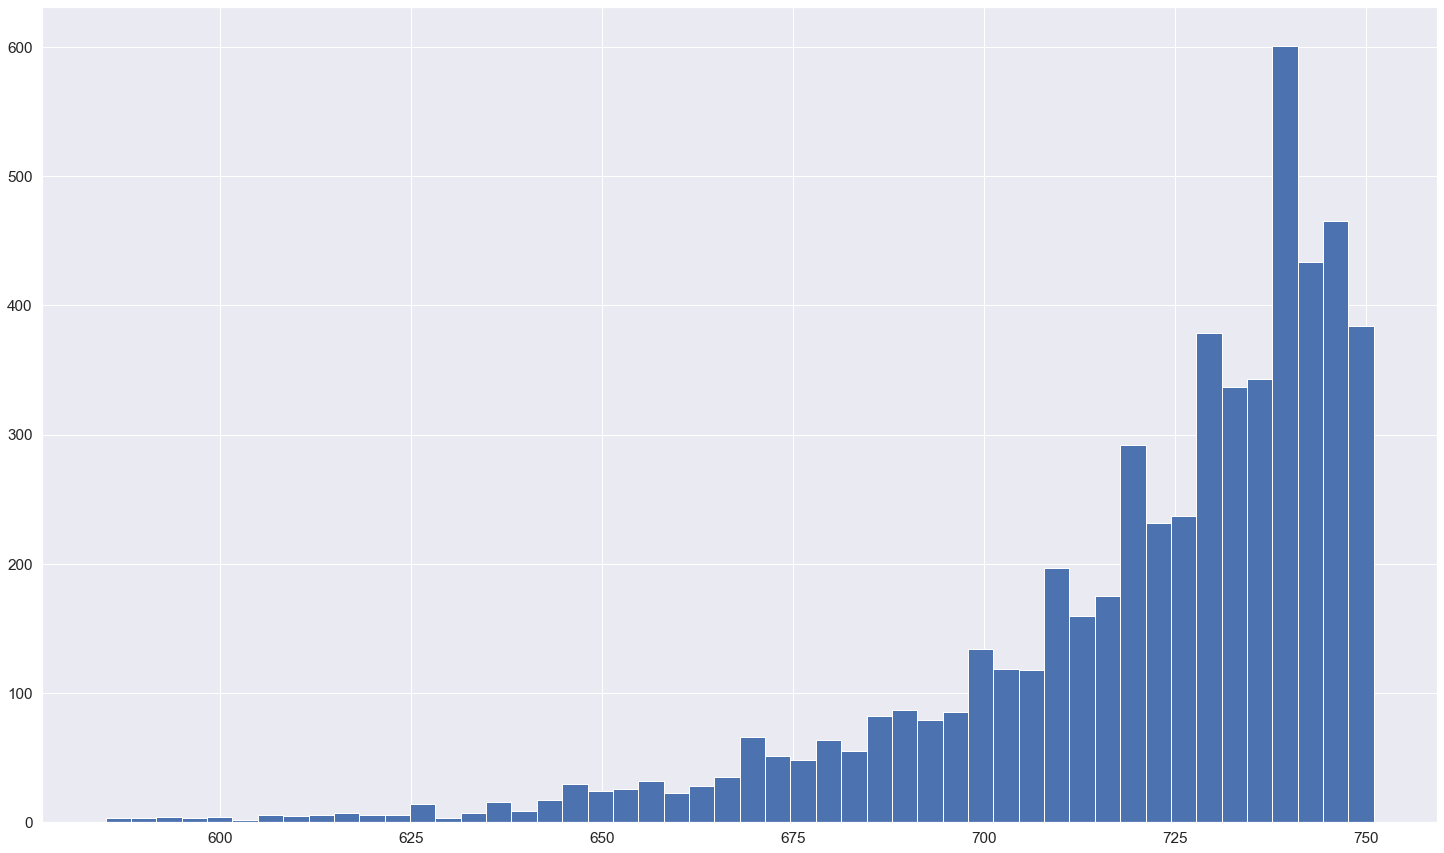

In [177]:
df_train[df_train['Credit Score'] < 1000]['Credit Score'].hist(figsize=(25,15), bins=50)

<AxesSubplot:>

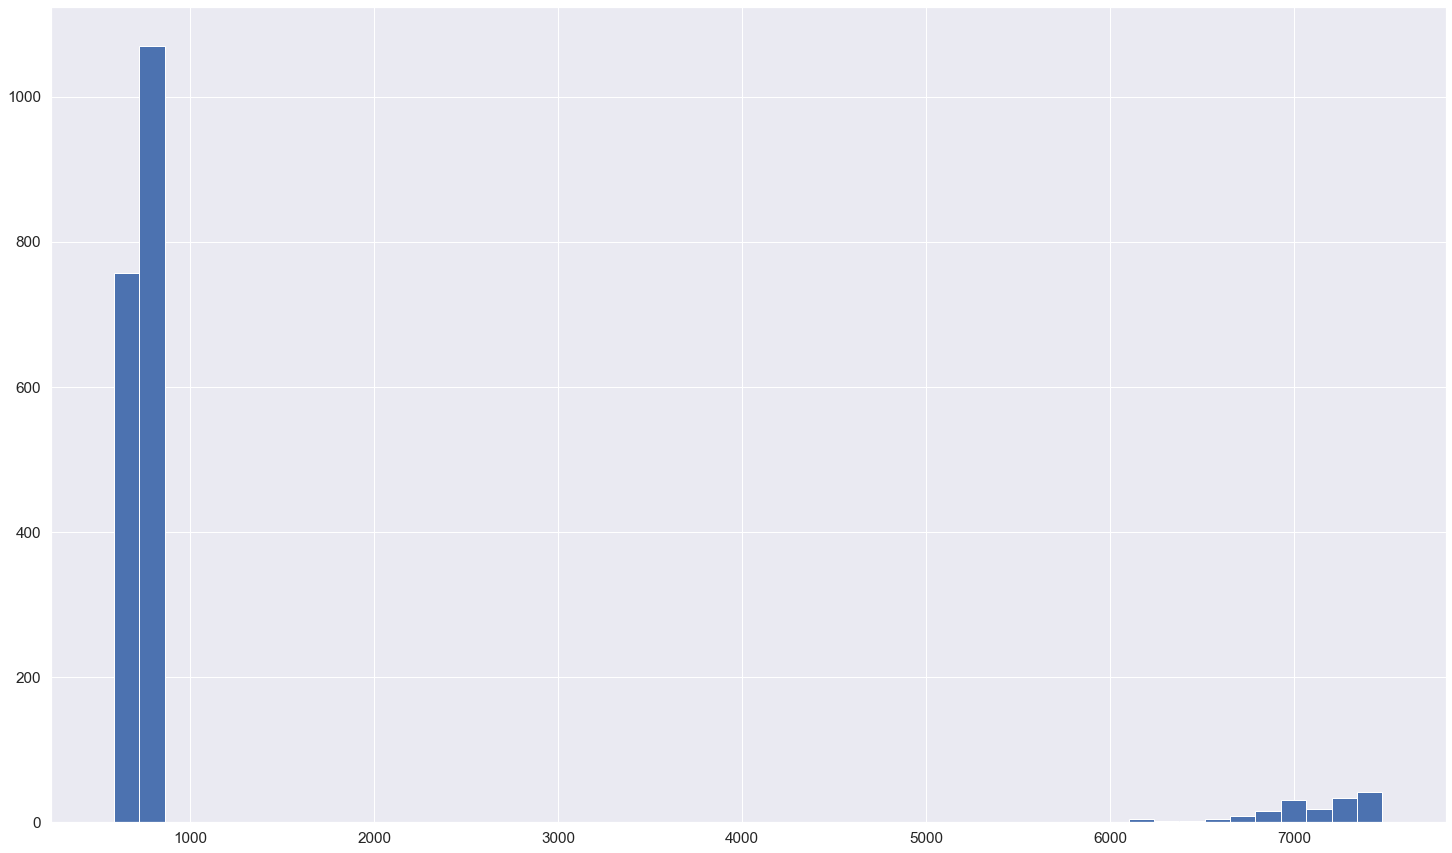

In [178]:
df_test['Credit Score'].hist(figsize=(25,15), bins=50)

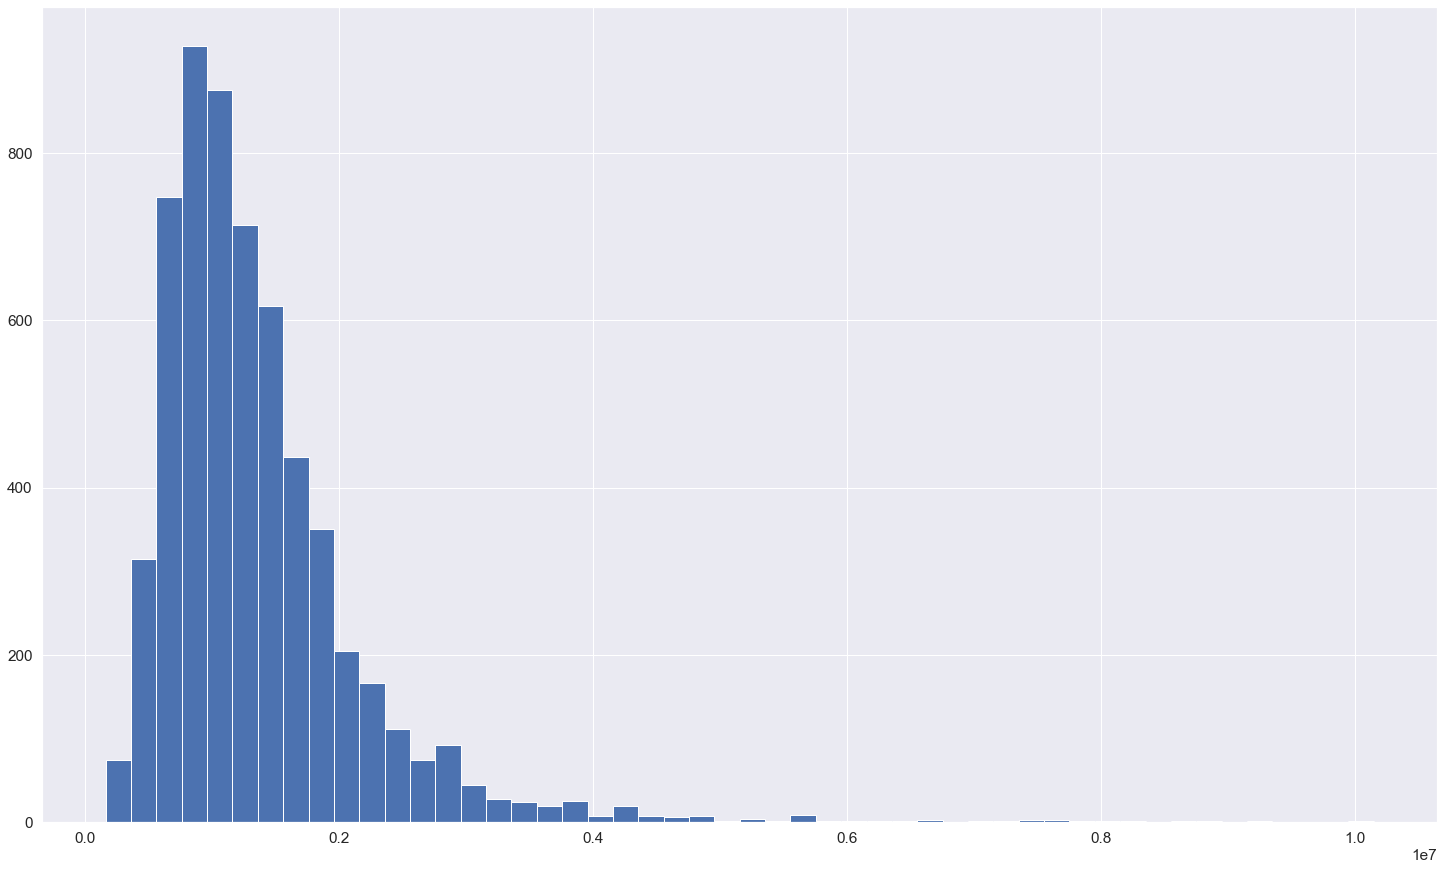

In [179]:
hist1 = df_train['Annual Income'].hist(figsize=(25,15), bins=50)

Странный горб на Credit Score

In [180]:
df_train[df_train['Credit Score'] < 1000].tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7490,Own Home,1368000.0,10+ years,0.0,20.0,26.7,897842.0,0.0,69.0,0.0,debt consolidation,Short Term,683650.0,517199.0,29868.0,688.0,1
7491,Home Mortgage,2833185.0,6 years,0.0,18.0,21.3,280170.0,0.0,6.0,0.0,debt consolidation,Short Term,437404.0,108889.0,61150.0,704.0,0
7493,Rent,1257610.0,8 years,0.0,14.0,16.5,821480.0,0.0,58.0,0.0,debt consolidation,Long Term,448052.0,167428.0,27562.0,676.0,1
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0


In [181]:
df_train[df_train['Credit Score'] > 1000].tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1


In [182]:
df_train[df_train['Credit Score'] > 1000].count()

Home Ownership                  400
Annual Income                   400
Years in current job            382
Tax Liens                       400
Number of Open Accounts         400
Years of Credit History         400
Maximum Open Credit             400
Number of Credit Problems       400
Months since last delinquent    184
Bankruptcies                    397
Purpose                         400
Term                            400
Current Loan Amount             400
Current Credit Balance          400
Monthly Debt                    400
Credit Score                    400
Credit Default                  400
dtype: int64

In [183]:
df_train[(df_train['Credit Score'] > 1000) & (df_train['Credit Score'] % 10 == 0)].count()

Home Ownership                  400
Annual Income                   400
Years in current job            382
Tax Liens                       400
Number of Open Accounts         400
Years of Credit History         400
Maximum Open Credit             400
Number of Credit Problems       400
Months since last delinquent    184
Bankruptcies                    397
Purpose                         400
Term                            400
Current Loan Amount             400
Current Credit Balance          400
Monthly Debt                    400
Credit Score                    400
Credit Default                  400
dtype: int64

In [184]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = df[['Months since last delinquent', 'Credit Score']].median()
        
    def transform(self, df):
        """Трансформация данных"""
        # Пропуски в Annual Income, Years in current job, Months since last delinquent, Bankruptcies и Credit Score
        
        # Years in current job
        df['Years in current job'].fillna('< 1 year', inplace=True)
        
        # Months since last delinquent
        df['Months since last delinquent'].fillna(self.medians['Months since last delinquent'], inplace=True)
        
        # Bankruptcies
        #df['Bankruptcies'].fillna(lambda x: 1.0 if x['Number of Credit Problems'] >= 1 else 0.0, inplace=True)
        df['Bankruptcies'].fillna(-1, inplace=True)
        df.loc[(df['Number of Credit Problems'] >= 1) & (df['Bankruptcies'] < 0), 'Bankruptcies'] = 1
        df.loc[df['Bankruptcies'] == -1, 'Bankruptcies'] = 0
        df['Bankruptcies'] = df['Bankruptcies'].astype(np.int64)
        
        # Credit Score
        # Предположим, что в признаке Credit Score > 1000 ошибка на 1 порядок
        #df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score'] / 10
        
        df['Credit Score cat'] = 0
        
        # Для CatBooster при обучении лучше не заполнять признаки, а записать нулевую категорию

        df.loc[df['Credit Score'] < 600, 'Credit Score cat'] = 1
        
        for i in range(1, 21):
            df.loc[(df['Credit Score'] >= (i * 10) + 600) & 
                   (df['Credit Score'] < ((i + 1) * 10) + 600), 'Credit Score cat'] = i
       
        df.loc[df['Credit Score'] >= (21 * 10) + 600, 'Credit Score'] = 0
        
        df['Credit Score cat'] = df['Credit Score cat'].astype(np.int64)
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        # Annual Income
        
        df['Annual Income cat'] = 0
        
        df.loc[df['Annual Income'] < 500000, 'Annual Income cat'] = 1
        
        for i in range(1, 16):
            df.loc[(df['Annual Income'] >= (i * 250000) + 500000) & 
                   (df['Annual Income'] < ((i + 1) * 250000) + 500000), 'Annual Income cat'] = i
       
        df.loc[df['Annual Income'] >= (16 * 250000) + 500000, 'Annual Income cat'] = 16
        
        df['Annual Income cat'] = df['Annual Income cat'].astype(np.int64)
        
        #df.drop(columns=['Annual Income', 'Credit Score'], axis=1, inplace=True)
        df.drop(columns=['Annual Income'], axis=1, inplace=True)
        return df
    
    def normalize(self, df, targegt_name, num_feature_names, cat_feature_names):
        scaler = StandardScaler()
        df_norm = df.copy()
        df_norm[num_feature_names] = scaler.fit_transform(df_norm[num_feature_names])
        df = df_norm.copy()
        
        for colname in cat_feature_names:
            df[colname] = pd.Categorical(df[colname])

In [185]:
df_train_cp = df_train.copy()

pipe = DataPipeline()
pipe.fit(df_train_cp)
pipe.transform(df_train_cp)

df_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Years in current job          7500 non-null   object 
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   int64  
 9   Purpose                       7500 non-null   object 
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

<AxesSubplot:>

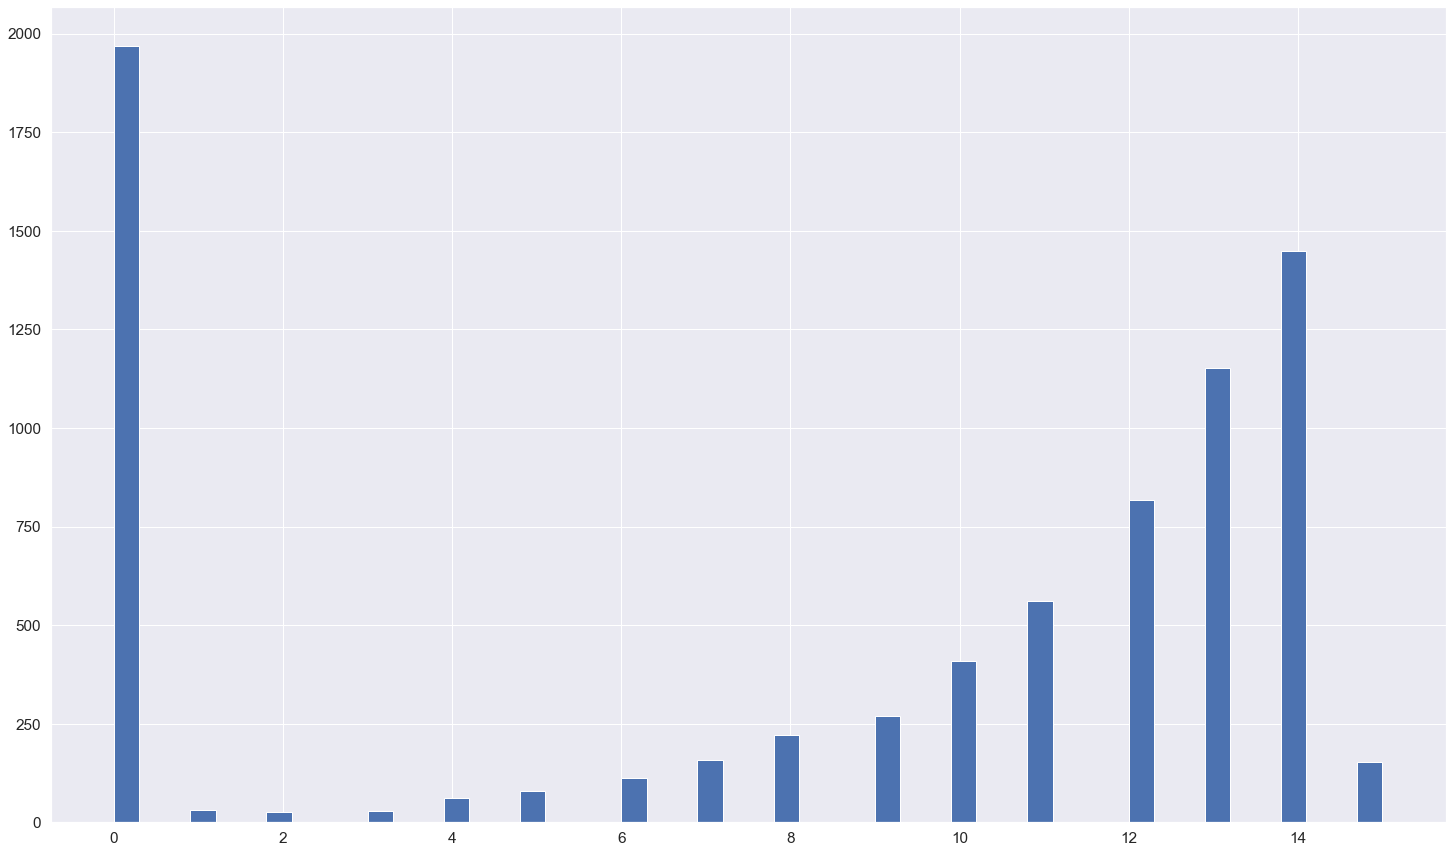

In [186]:
df_train_cp['Credit Score cat'].hist(figsize=(25,15), bins=50)

<AxesSubplot:>

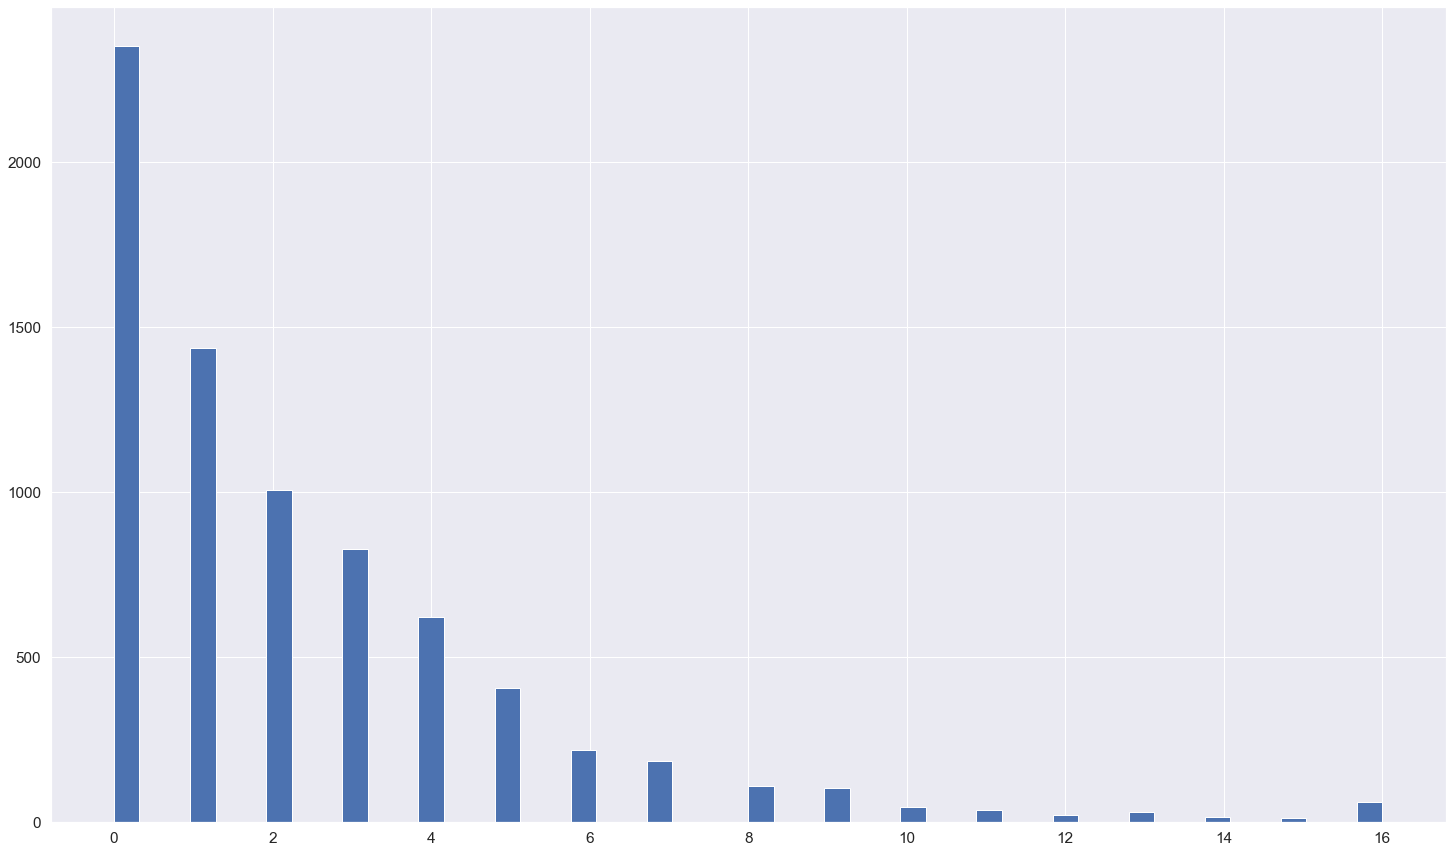

In [187]:
#df_train_cp.describe()
df_train_cp['Annual Income cat'].hist(figsize=(25,15), bins=50)

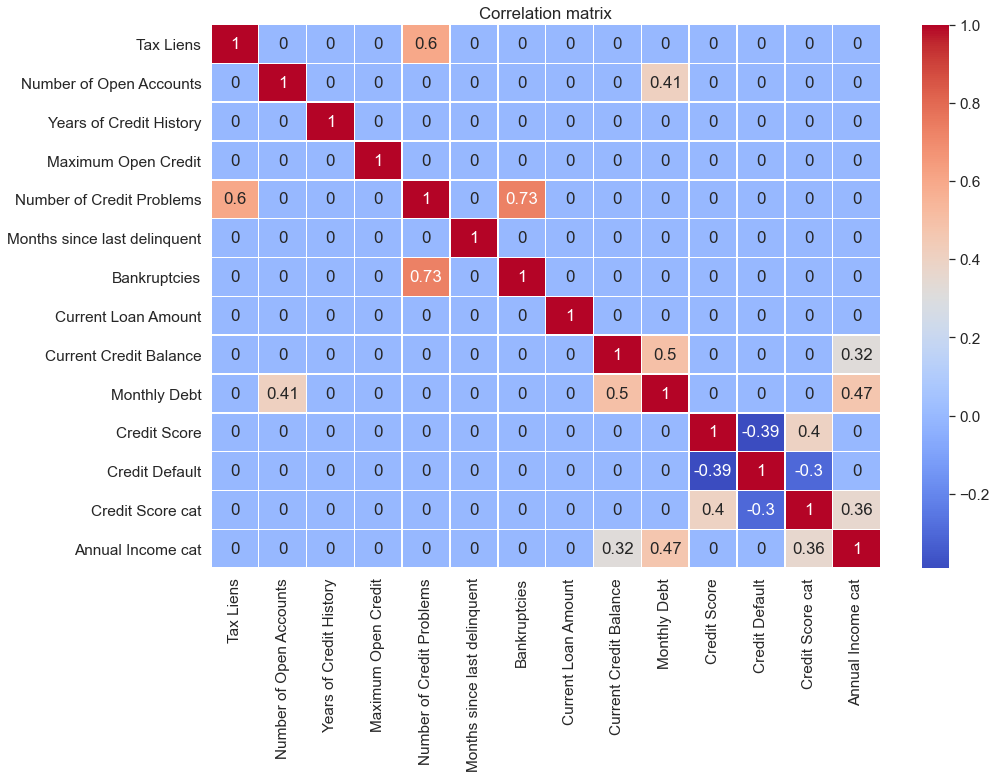

In [188]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train_cp.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

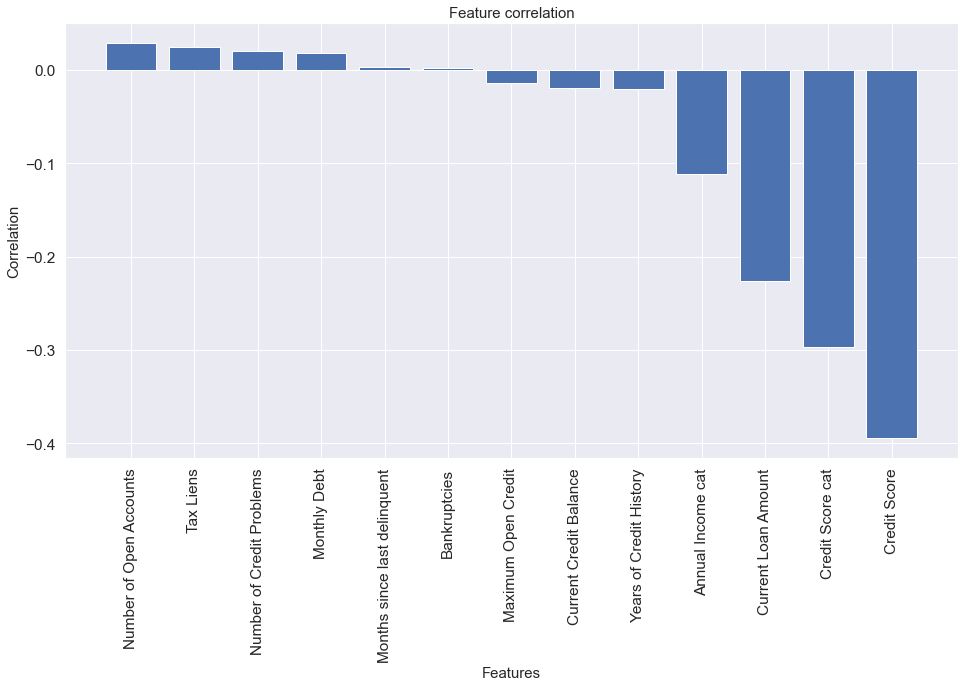

In [189]:
correlation = df_train_cp.corrwith(df_train_cp['Credit Default']).sort_values(ascending=False)
correlation.drop('Credit Default', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

**Выделение признакового описания и целевой переменной**

In [190]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Bankruptcies', 'Purpose', 'Term', 'Credit Score cat', 
                     'Annual Income cat']

Нормализация датасета

In [191]:
pipe.normalize(df_train_cp, TARGET_NAME, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES)

Разделение и балансировка датасета

In [192]:
X = df_train_cp[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]
y = df_train_cp[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle = True,
    test_size = 0.3,
    random_state = 21
)

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
  
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [193]:
# from catboost import Pool, CatBoostClassifier

# train_data = [["France", 1924, 44],
#               ["USA", 1932, 37],
#               ["USA", 1980, 37]]

# eval_data = [["USA", 1996, 197],
#              ["France", 1968, 37],
#              ["USA", 2002, 77]]

# cat_features = [0]

# train_label = [1, 1, 0]
# eval_label = [0, 0, 1]

# train_dataset = Pool(data=train_data,
#                      label=train_label,
#                      cat_features=cat_features)

# eval_dataset = Pool(data=eval_data,
#                     label=eval_label,
#                     cat_features=cat_features)

# # Initialize CatBoostClassifier
# model = CatBoostClassifier(iterations=100)
# # Fit model with `use_best_model=True`

# model.fit(train_dataset,
#           use_best_model=True,
#           eval_set=eval_dataset)

# print("Count of trees in model = {}".format(model.tree_count_))

Подбор гиперпараметров

In [194]:
train_dataset = catb.Pool(
    X_train,
    y_train,
    cat_features=CAT_FEATURE_NAMES
)

eval_dataset = catb.Pool(
    X_test,
    y_test,
    cat_features=CAT_FEATURE_NAMES
)

In [195]:
grid = {
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
        'iterations': [100, 200, 400, 800, 1200],
       }

model_catb = catb.CatBoostClassifier(iterations=400,
                                     silent=True,
                                     eval_metric='F1',
                                     one_hot_max_size=20,
                                     auto_class_weights='SqrtBalanced'
                                    )
randomized_search_result = model_catb.randomized_search(grid,
                                                        train_dataset,
                                                        cv=5,
                                                        partition_random_seed=21,
                                                        n_iter=20,
                                                        shuffle=True,
                                                        stratified=True,
                                                        verbose=False
                                                       )
# params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
#           'max_depth':[3, 5, 7]}
# cv=KFold(n_splits=3, random_state=21, shuffle=True)
# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(train_dataset)

model_catb.fit(train_dataset,
               use_best_model=True,
               eval_set=eval_dataset
              )


bestTest = 0.7106224859
bestIteration = 173


bestTest = 0.7517252329
bestIteration = 398


bestTest = 0.7388351466
bestIteration = 399


bestTest = 0.8371745491
bestIteration = 657


bestTest = 0.7165220268
bestIteration = 678


bestTest = 0.8506807772
bestIteration = 762


bestTest = 0.6929012042
bestIteration = 98


bestTest = 0.6912248277
bestIteration = 97


bestTest = 0.7848483558
bestIteration = 99


bestTest = 0.7169905782
bestIteration = 198


bestTest = 0.8164938098
bestIteration = 194


bestTest = 0.8494556464
bestIteration = 393


bestTest = 0.8654428892
bestIteration = 795


bestTest = 0.7639134381
bestIteration = 792


bestTest = 0.8609627753
bestIteration = 1149


bestTest = 0.8495266772
bestIteration = 98


bestTest = 0.8459986015
bestIteration = 192


bestTest = 0.8449102112
bestIteration = 199


bestTest = 0.8558164912
bestIteration = 333


bestTest = 0.8582599943
bestIteration = 339

Training on fold [0/5]

bestTest = 0.8653651689
bestIteration = 746

Training on fo

In [197]:
randomized_search_result['params']

{'depth': 6, 'l2_leaf_reg': 5, 'iterations': 800, 'learning_rate': 0.3}

In [198]:
%%time

final_model = catb.CatBoostClassifier(depth=6,
                                      l2_leaf_reg=5,
                                      iterations=800,
                                      learning_rate=0.3,
                                      silent=True, 
                                      random_state=21,
                                      boosting_type='Plain',
                                      eval_metric='F1',
                                      auto_class_weights='SqrtBalanced'
                                     )

final_model.fit(train_dataset, use_best_model=True, eval_set = eval_dataset)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      3771
           1       0.68      0.62      0.65      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.70      0.70      6729
weighted avg       0.70      0.70      0.70      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.49      0.59      0.53       634

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1232  384
1                263  371
Wall time: 59.5 s


Важности признаков

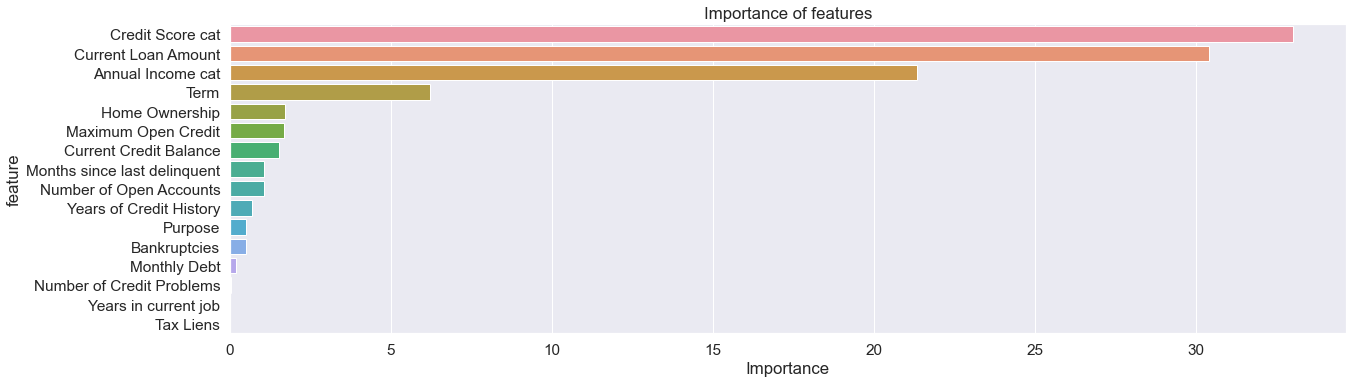

,feature,importance
14,Credit Score cat,33.014557
6,Current Loan Amount,30.427634
15,Annual Income cat,21.332812
13,Term,6.230995
9,Home Ownership,1.701456
3,Maximum Open Credit,1.672770
7,Current Credit Balance,1.512051
5,Months since last delinquent,1.072824
1,Number of Open Accounts,1.056929
2,Years of Credit History,0.698779


In [199]:
show_feature_importances(NUM_FEATURE_NAMES + CAT_FEATURE_NAMES, final_model.get_feature_importance(), get_list=True)

In [200]:
df_test_cp = df_test.copy()

pipe.transform(df_test_cp)
pipe.normalize(df_test_cp, TARGET_NAME, NUM_FEATURE_NAMES, CAT_FEATURE_NAMES)

Классификация по обученной модели

In [201]:
X_test_pred = df_test_cp[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]
y_test_pred = final_model.predict(X_test_pred)

In [202]:
preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_test_pred.shape[0]), 'Credit Default': y_test_pred})
preds_final.to_csv(PREDICTION_PATH, index=False, encoding='utf-8', sep=',')

In [203]:
preds_final.tail(10)

,Id,Credit Default
2490,2490,0
2491,2491,0
2492,2492,1
2493,2493,0
2494,2494,1
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0
2499,2499,1


In [204]:
preds_final[preds_final['Credit Default'] == 1].count()

Id                830
Credit Default    830
dtype: int64